In [87]:
import pandas as pd

df = pd.read_csv('/Users/tyco/Desktop/MADS/sanovo/data/raw/HSTMachineError.csv')

# Convert to datetime
df['MerDate'] = pd.to_datetime(df['MerDate'])

# Sort by machine and time
df = df.sort_values(by=['MerNumber', 'MerDate'])
df.head(5)

,MerId,MerType,MerDate,MerNumber,MerSubNumber,MerData1,MerData2,MerData3,MerData4,MerData5,MerMinId,MerText,MerDeviceType,MerDeviceNumber,MerPriority
202,11897387,8,2025-01-30 10:25:46,0,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0
401,11897586,8,2025-01-30 10:31:04,0,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0
427,11897613,8,2025-01-30 10:31:15,0,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0
1203,11898389,8,2025-01-30 10:44:54,0,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0
1242,11898428,8,2025-01-30 10:46:11,0,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0


In [88]:
#filter data
data_filtered = df[(df['MerNumber'] >= 400) & (df['MerType'].between(21, 24)) | (df['MerType'] == 8)]

In [89]:
# we create a machine stop feature
data_filtered['Machine_stop'] = data_filtered.apply(lambda row: 1 if row['MerType'] == 8 and row['MerNumber'] == 1 else 0, axis=1)

/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_69543/1883778272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Machine_stop'] = data_filtered.apply(lambda row: 1 if row['MerType'] == 8 and row['MerNumber'] == 1 else 0, axis=1)


In [90]:
#create error column
data_filtered['Lane_error_start_stop'] = data_filtered['MerType'].apply(lambda x: 1 if x in [21, 22] else 0)

/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_69543/815759666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Lane_error_start_stop'] = data_filtered['MerType'].apply(lambda x: 1 if x in [21, 22] else 0)


# We create a rolling time window before each stop event

In [91]:
def calculate_lane_error_durations(window):
    """
    Given a window of events, calculate total error duration per lane.
    Assumes Lane_error_start_stop == 1 means error start, and 0 means stop.
    Returns total error duration in seconds across all lanes in the window.
    """
    window = window.sort_values('MerDate')
    error_durations = []

    current_start = {}

    for _, row in window.iterrows():
        lane = row['MerSubNumber']
        if row['Lane_error_start_stop'] == 1 and lane not in current_start:
            current_start[lane] = row['MerDate']
        elif row['Lane_error_start_stop'] == 0 and lane in current_start:
            start_time = current_start.pop(lane)
            duration = (row['MerDate'] - start_time).total_seconds()
            error_durations.append(duration)

    # If errors are still ongoing (no stop event), calculate up to end of window
    window_end = window['MerDate'].max()
    for lane, start_time in current_start.items():
        duration = (window_end - start_time).total_seconds()
        error_durations.append(duration)

    return sum(error_durations)  # or return the list if you want more stats


Create train and test set

In [92]:
#sort the data chronologically
data_filtered = data_filtered.sort_values('MerDate', ascending=True)

# Determine the cutoff date for the split
cutoff_date = data_filtered['MerDate'].quantile(0.8)

print(cutoff_date)

# Split the data based on the cutoff date
X_train = data_filtered[data_filtered['MerDate'] < cutoff_date]
X_test = data_filtered[data_filtered['MerDate'] >= cutoff_date]
y_train = data_filtered[data_filtered['MerDate'] < cutoff_date]
y_test = data_filtered[data_filtered['MerDate'] >= cutoff_date]

2025-03-28 08:07:48


In [102]:
from datetime import timedelta
import random

def feature_engineering(df, look_back_seconds):
    window_seconds = look_back_seconds  # Look back 300 seconds, 5 minutes
    features = []
    labels = []
    
    # Loop over all rows where the machine stopped
    stop_rows = data_filtered[data_filtered['Machine_stop'] == 1]

    for idx, stop_row in stop_rows.iterrows():
        machine_id = stop_row['MerNumber']
        stop_time = stop_row['MerDate']

        # Get rows from same machine in the window before stop
        mask = (
            (data_filtered['MerNumber'] == machine_id) &
            (data_filtered['MerDate'] < stop_time) &
            (data_filtered['MerDate'] >= stop_time - timedelta(seconds=window_seconds))
        )
        window = data_filtered[mask]

        # Skip if window is empty
        if window.empty:
            continue

        # Feature extraction

        num_lanes_error = window[window['MerType'] == 21]['MerSubNumber'].nunique()
        num_lanes_warning = window[window['MerType'] == 22]['MerSubNumber'].nunique()
        total_events = len(window)
        unique_lanes = window['MerSubNumber'].nunique()

        lane_counts = window['MerSubNumber'].value_counts()
        repeated_failures = (lane_counts > 1).sum()

        # Optional: set-based features (can one-hot encode later)
        lanes_error = sorted(window[window['MerType'] == 21]['MerSubNumber'].unique())
        lanes_warning = sorted(window[window['MerType'] == 22]['MerSubNumber'].unique())

        total_lane_error_duration = calculate_lane_error_durations(window)
        feature_row = {
            'merdate' : stop_time,
            'num_lanes_error': num_lanes_error,
            'num_lanes_warning': num_lanes_warning,
            'total_events': total_events,
            'unique_lanes': unique_lanes,
            'repeated_lane_errors': repeated_failures,
            # 'lanes_error_str': "_".join(map(str, lanes_error)),   # Optional for later encoding
            # 'lanes_warning_str': "_".join(map(str, lanes_warning)),
            'lane_error_duration_s': total_lane_error_duration
        }

        features.append(feature_row)

        label_row = {
            'merdate' : stop_time,
            'stop' : 1
        }

        labels.append(label_row)  # This is a stop


    # Get all rows where the machine didn't stop
    non_stop_rows = data_filtered[data_filtered['Machine_stop'] == 0]

    # Randomly sample the same number of non-stop rows as stop rows
    random_non_stop_rows = non_stop_rows.sample(n=len(stop_rows), random_state=42)

    # Loop over all rows in the random non-stop sample
    for idx, non_stop_row in random_non_stop_rows.iterrows():
        machine_id = non_stop_row['MerNumber']
        non_stop_time = non_stop_row['MerDate']

        # Get rows from the same machine in the window before the non-stop event
        mask = (
            (data_filtered['MerNumber'] == machine_id) &
            (data_filtered['MerDate'] < non_stop_time) &
            (data_filtered['MerDate'] >= non_stop_time - timedelta(seconds=window_seconds))
        )
        window = data_filtered[mask]

        # Skip if window is empty
        if window.empty:
            continue

        # Feature extraction
        num_lanes_error = window[window['MerType'] == 21]['MerSubNumber'].nunique()
        num_lanes_warning = window[window['MerType'] == 22]['MerSubNumber'].nunique()
        total_events = len(window)
        unique_lanes = window['MerSubNumber'].nunique()

        lane_counts = window['MerSubNumber'].value_counts()
        repeated_failures = (lane_counts > 1).sum()

        # Optional: set-based features (can one-hot encode later)
        lanes_error = sorted(window[window['MerType'] == 21]['MerSubNumber'].unique())
        lanes_warning = sorted(window[window['MerType'] == 22]['MerSubNumber'].unique())

        total_lane_error_duration = calculate_lane_error_durations(window)
        feature_row = {
            'merdate' : non_stop_time,
            'num_lanes_error': num_lanes_error,
            'num_lanes_warning': num_lanes_warning,
            'total_events': total_events,
            'unique_lanes': unique_lanes,
            'repeated_lane_errors': repeated_failures,
            # 'lanes_error_str': "_".join(map(str, lanes_error)),   # Optional for later encoding
            # 'lanes_warning_str': "_".join(map(str, lanes_warning)),
            'lane_error_duration_s': total_lane_error_duration
        }

        features.append(feature_row)

        label_row = {
            'merdate' : non_stop_time,
            'stop' : 0
        }

        labels.append(label_row)  # This is not a stop
        
        features = pd.DataFrame(features)
        labels = pd.DataFrame(labels)

        #sort features and labels on MerDate
        features = features.sort_values('merdate', ascending=True)
        labels = labels.sort_values('merdate', ascending=True)

        return features, labels
    
features, labels = feature_engineering(data_filtered, 300)

In [103]:
# Calculate the split index
split_index = int(len(df) * 0.8)

# Split the DataFrame
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Print the sizes of the splits
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 1634981
Test set size: 408746


In [104]:
test = pd.DataFrame(features)
test

,merdate,num_lanes_error,num_lanes_warning,total_events,unique_lanes,repeated_lane_errors,lane_error_duration_s
0,2025-01-30 10:31:17,0,0,1,1,0,0.0
1,2025-01-30 10:46:59,0,0,1,1,0,0.0
2,2025-01-30 10:52:58,0,0,1,1,0,0.0
3,2025-01-30 11:04:20,0,0,1,1,0,0.0
4,2025-01-30 11:04:27,0,0,2,1,1,0.0
...,...,...,...,...,...,...,...
22856,2025-04-08 20:06:19,0,0,33,1,1,0.0
22857,2025-04-08 20:06:26,0,0,33,1,1,0.0
22858,2025-04-08 20:06:34,0,0,33,1,1,0.0
22859,2025-04-08 20:06:55,0,0,32,1,1,0.0


In [96]:
label = pd.DataFrame(labels)
label

,merdate,stop
0,2025-01-30 10:31:17,1
1,2025-01-30 10:46:59,1
2,2025-01-30 10:52:58,1
3,2025-01-30 11:04:20,1
4,2025-01-30 11:04:27,1
...,...,...
22856,2025-04-08 20:06:19,1
22857,2025-04-08 20:06:26,1
22858,2025-04-08 20:06:34,1
22859,2025-04-08 20:06:55,1


# Train a Random Forest

In [97]:
labels

,merdate,stop
0,2025-01-30 10:31:17,1
1,2025-01-30 10:46:59,1
2,2025-01-30 10:52:58,1
3,2025-01-30 11:04:20,1
4,2025-01-30 11:04:27,1
...,...,...
22856,2025-04-08 20:06:19,1
22857,2025-04-08 20:06:26,1
22858,2025-04-08 20:06:34,1
22859,2025-04-08 20:06:55,1


In [98]:
# Split the data based on the cutoff date
cutoff_date = features['merdate'].quantile(0.8)

X_train = features[features['merdate'] < cutoff_date]
X_test = features[features['merdate'] >= cutoff_date]
y_train = labels[labels['merdate'] < cutoff_date]['stop']
y_test = labels[labels['merdate'] >= cutoff_date]['stop']


In [99]:
# Drop the 'merdate' column for every split
X_train = X_train.drop(columns=['merdate'])
X_test = X_test.drop(columns=['merdate'])

In [100]:
X_train

,num_lanes_error,num_lanes_warning,total_events,unique_lanes,repeated_lane_errors,lanes_error_str,lanes_warning_str,lane_error_duration_s
0,0,0,1,1,0,,,0.0
1,0,0,1,1,0,,,0.0
2,0,0,1,1,0,,,0.0
3,0,0,1,1,0,,,0.0
4,0,0,2,1,1,,,0.0
...,...,...,...,...,...,...,...,...
18283,0,0,10,1,1,,,0.0
18284,0,0,10,2,1,,,0.0
18285,0,0,11,2,2,,,0.0
18286,0,0,12,2,2,,,0.0



Feature Importances:
                 Feature  Importance
5  lane_error_duration_s    0.397046
2           total_events    0.338228
1      num_lanes_warning    0.264702
3           unique_lanes    0.000021
4   repeated_lane_errors    0.000003
0        num_lanes_error    0.000000
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00     18288

    accuracy                           1.00     18289
   macro avg       1.00      1.00      1.00     18289
weighted avg       1.00      1.00      1.00     18289

Test Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4573

    accuracy                           1.00      4573
   macro avg       1.00      1.00      1.00      4573
weighted avg       1.00      1.00      1.00      4573



/Users/tyco/Desktop/MADS/sanovo/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

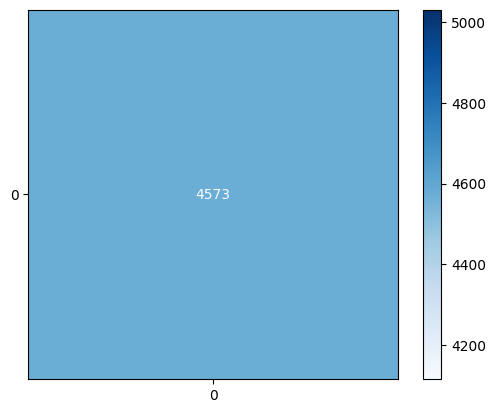

In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

X = features
y = labels

# Split the data based on the cutoff date
cutoff_date = features['merdate'].quantile(0.8)

X_train = features[features['merdate'] < cutoff_date]
X_test = features[features['merdate'] >= cutoff_date]
y_train = labels[labels['merdate'] < cutoff_date]['stop']
y_test = labels[labels['merdate'] >= cutoff_date]['stop']

# Drop the 'merdate' column for every split
X_train = X_train.drop(columns=['merdate'])
X_test = X_test.drop(columns=['merdate'])

# Handle categorical (lane string patterns) + numeric
# text_features = ['lanes_error_str', 'lanes_warning_str']
numeric_features = [col for col in X_train.columns]


preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features)
    # ('text', CountVectorizer(), 'lanes_error_str')
], remainder='drop')

model = make_pipeline(preprocessor, RandomForestClassifier())

model.fit(X_train, y_train)

# Access the RandomForestClassifier from the pipeline
rf_classifier = model.named_steps['randomforestclassifier']

# # Print feature importance
feature_importances = rf_classifier.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)

# Extract feature names from ColumnTransformer
# def get_feature_names(column_transformer):
#     feature_names = []

#     for name, transformer, column in column_transformer.transformers_:
#         if transformer == 'drop':
#             continue
#         if hasattr(transformer, 'get_feature_names_out'):
#             # e.g., for CountVectorizer
#             names = transformer.get_feature_names_out()
#         else:
#             # Use original column names for numeric (e.g., StandardScaler)
#             names = column if isinstance(column, list) else [column]
#         feature_names.extend(names)

#     return feature_names

# Access ColumnTransformer inside pipeline
# ct = model.named_steps['columntransformer']
# actual_feature_names = get_feature_names(ct)

# Now this will work
# importance_df = pd.DataFrame({
#     'Feature': actual_feature_names,
#     'Importance': rf_classifier.feature_importances_
# }).sort_values(by='Importance', ascending=False)

# print("\nFeature Importances:")
# print(importance_df)

# Make predictions
y_pred = model.predict(X_test)

# Print precision, recall, and F1 score
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=['Non-Stop', 'Stop']))
# print("Accuracy:", model.score(X_test, y_test))


# Evaluate on training data
train_preds = model.predict(X_train)
print("Training Classification Report:")
print(classification_report(y_train, train_preds))

# Evaluate on test data
test_preds = model.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, test_preds))


# Evaluate the model using confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.named_steps['randomforestclassifier'].classes_)
disp.plot(cmap='Blues')


# Ensure temporal order is respected (i.e., no future data leaks into the past)

PAS DIT AAN IN JE ALGORITME!